# Scalability of distributed algorithms

In [27]:
import math
def t_cpnormal(n, f, e, s):
    # add 2 or not?
    return  (e / f) * (s + 2 * (s + s * s)) / n
def t_cpmax(f, emax, s):
    return (emax / f ) * (s + 2 * (s + s * s))
def t_cpmax2(f, e, emax, s):
    return max(t_cpmax(f, e, s), t_cpmax(f, emax, s))
def t_cp(n, f, e, emax, s):
    return max(t_cpnormal(n, f, e, s), t_cpmax(f, emax, s))
    #return t_cpnormal(n, f, e, s) if n < 20 else t_cpmax(f, emax, s)
def t_cm(n):
    return 0
def t_total(n, f, e, emax, s):
    return t_cp(n, f, e, emax, s) + t_cm(n)
def speedup(n, f, e, emax, s):
    return t_total(1, f, e, emax, s) / t_total(n, f, e, emax, s)
def mape(x1array, y1array, x2array, y2array):
    e = 0
    n = len(x1array)
    for i in range(n):
        x1 = x1array[i]
        i2 = x2array.index(x1)
        e += abs( (y1array[i] - y2array[i2]) / y1array[i])
        print(y1array[i],y2array[i2])
    return 100 / n * e

Lets plot graphs to see how the total time behave depending on the number of nodes:

In [9]:
import numpy as np
def avgEdges(vertices, edges, partitions):
    return edges / partitions;
def avgEdgesAdjusted(vertices, edges, partitions):
    return edges / partitions * (2 - (1 / partitions - 1 / vertices) / (1 - 1 / vertices))
def avgEdgesAdjustedMax(vertices, edges, maxDegree, partitions):
    avgEdges = avgEdgesAdjusted(vertices, edges, partitions)
    return list(map(lambda avgEdge: max(avgEdge, maxDegree), avgEdges))
def avgEdgesSampledAdjusted(fileName, partitions):
    degree = np.loadtxt(fileName,
                        dtype= { 'names': ('edges', 'frequency'), 'formats': (np.int, np.int) })
    degree_edges = degree['edges']
    degree_freqs = degree['frequency']
    totalVertices = np.sum(degree_freqs)
    twiceTotalEdges = np.sum(degree_edges * degree_freqs)
    plotX = np.arange(1, partitions, dtype=np.int)
    plotMax = np.zeros(partitions, dtype=np.float)
    plotMax[1] = twiceTotalEdges / 2
    for p in range(2, partitions):
        partitionsCuSum = np.empty((p,), dtype=np.int)
        partitionsCuSum[:] = 0
        vertexIndex = 0
        for i in range(len(degree_edges)):
            edges = degree_edges[i]
            for j in range(degree_freqs[i]):
                pIndex = vertexIndex % p #randomInt
                vertexIndex += 1
                partitionsCuSum[pIndex] += edges
        maxEdges = np.max(partitionsCuSum)
        # a simpler version of shared edges is division by 2
        #plotMax[p] =  maxEdges - totalVertices / p * (totalVertices / p - 1)/2 * twiceTotalEdges / (totalVertices *(totalVertices - 1))   #/ 2
        #plotMax[p] =  maxEdges - (1 - p / totalVertices) * twiceTotalEdges / (2 * p * p * p * (1 - 1 / totalVertices))
        plotMax[p] =  maxEdges - (1 - p / totalVertices) * twiceTotalEdges / (2 * p * p * (1 - 1 / totalVertices))
    plotData = {'partitions':plotX, 'max':plotMax}
    return plotData

### Number of edges per node/partition

c:\python35\lib\site-packages\matplotlib\cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


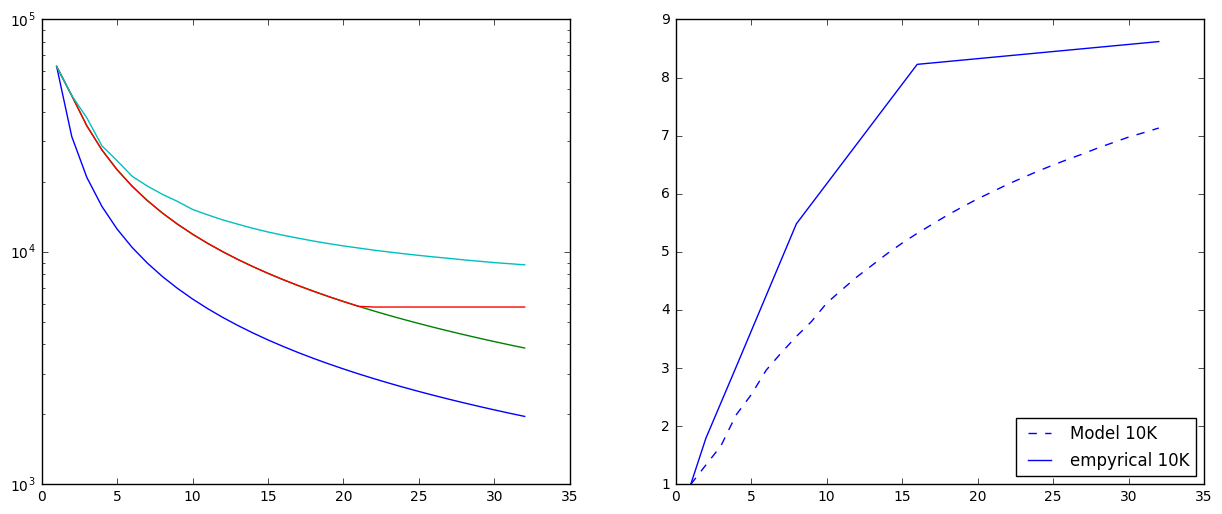

In [16]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
maxN = 33
n = np.arange(1, maxN)
graphs = np.genfromtxt("res/graph/stats.txt", skip_header = 1,
                       dtype= {'names': ('name', 'vertices', 'edges', 'maxDegree'),
                               'formats': ['a14','i4','i4','i4']})
plt.figure(1, figsize=(15, 6))    
for i in range(2, len(graphs) - 3):
    vertices = graphs['vertices'][i]
    edges = graphs['edges'][i]
    maxDegree = graphs['maxDegree'][i]
    name = graphs['name'][i].decode("utf-8")
    plt.subplot(121)
    plt.semilogy(n, avgEdges(vertices, edges, n), label='%s avg' % name)
    plt.semilogy(n, avgEdgesAdjusted(vertices, edges, n), label='%s avg adjusted' % name)
    plt.semilogy(n, avgEdgesAdjustedMax(vertices, edges, maxDegree, n), label='%s avg adjusted with max' % name)
    filename = 'res/graph/synthetic_' + '%s.degree_dist' % name
    sampled = avgEdgesSampledAdjusted(filename, maxN)
    plt.semilogy(n, sampled['max'][n], label='%s avg max sampled adjusted' % name)
    #plt.legend()
    plt.subplot(122)
    avgEdgesAdjustedMaxData = avgEdgesAdjustedMax(vertices, edges, maxDegree, n)
    #plt.plot(n, avgEdgesAdjustedMaxData[0] / avgEdgesAdjustedMaxData, ls="dashed", label = '%s avg max adjusted' % name)
    #plt.plot(n, avgEdges(vertices, edges, 1) / avgEdges(vertices, edges, n), ls="dotted", label = '%s avg adjusted' % name)
    #avgEdgesAdjustedSpeedup = avgEdgesAdjusted(vertices, edges, 1) / avgEdgesAdjusted(vertices, edges, n)
    #plt.plot(n, avgEdgesAdjustedSpeedup, ls="dotted", label = '%s avg adjusted' % name)
    avgSampledAdjustedSpeedup = sampled['max'][1] / sampled['max'][n]    
    plt.plot(n, avgSampledAdjustedSpeedup, ls="dashed", label = 'Model %s' % name)
# experimental data
plt.gca().set_color_cycle(None)
#plt.plot([1,2,4,8,16,32], [1, 1.4, 2.333333333, 3.5, 3.5, 3.5], label='empyrical 1K')
plt.plot([1,2,4,8,16,32], [1, 1.792079208, 3.016666667, 5.484848485, 8.227272727, 8.619047619], label='empyrical 10K')
#plt.plot([1,2,4,8,16,32], [1, 1.721916732, 3.031811895, 4.871111111, 6.871473354, 6.582582583], label='Experiment 100K')
#plt.plot([1,2,4,8,16,32], [1, 1.853391271, 3.434072345, 5.962317666, 8.582677165, 9.047033508], label='empyrical 1M')
#plt.plot([1,2,4,8,16,32], [1, 1.835121816, 3.422534304, 6.311737684, 9.595376419, 10.98896856], label='empyrical 10M')
plt.legend(loc = 4)

1.0 1.0
1.835121816 1.333333306
3.422534304 2.28134385564
6.311737684 4.23951605156
9.595376419 8.16517083878
10.98896856 15.8021808497
MAPE= 25.3706389573
[  1.           1.33333331   1.79576245   2.28134386   2.77305482
   3.26102026   3.74739075   4.23951605   4.71746148   5.23919143
   5.73611976   6.2249927    6.71190561   7.20172541   7.7069433
   8.16517084   8.64515781   9.12656069   9.61744168  10.09837886
  10.59117794  11.06315209  11.51769123  12.0590776   12.50574035
  12.96531684  13.39694563  13.96340523  14.40787243  14.89170956
  15.31009412  15.80218085]
[  1.           1.83512182   3.4225343    6.31173768   9.59537642
  10.98896856]


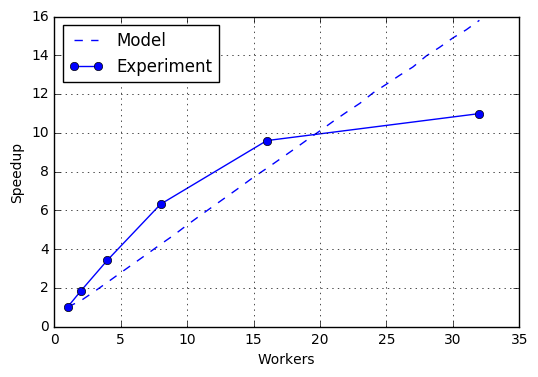

In [34]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
maxN = 33
n = np.arange(1, maxN)
graphs = np.genfromtxt("res/graph/stats.txt", skip_header = 1,
                       dtype= {'names': ('name', 'vertices', 'edges', 'maxDegree'),
                               'formats': ['a14','i4','i4','i4']})
i = 3
vertices = graphs['vertices'][i]
edges = graphs['edges'][i]
maxDegree = graphs['maxDegree'][i]
name = graphs['name'][i].decode("utf-8")
ax = plt.gca()
ax.grid(True)
filename = 'res/graph/synthetic_' + '%s.degree_dist' % name
sampled = avgEdgesSampledAdjusted(filename, maxN)
avgEdgesAdjustedMaxData = avgEdgesAdjustedMax(vertices, edges, maxDegree, n)
#plt.plot(n, avgEdgesAdjustedMaxData[0] / avgEdgesAdjustedMaxData, ls="dashed", label = '%s avg max adjusted' % name)
#plt.plot(n, avgEdges(vertices, edges, 1) / avgEdges(vertices, edges, n), ls="dotted", label = '%s avg adjusted' % name)
#avgEdgesAdjustedSpeedup = avgEdgesAdjusted(vertices, edges, 1) / avgEdgesAdjusted(vertices, edges, n)
#plt.plot(n, avgEdgesAdjustedSpeedup, ls="dotted", label = '%s avg adjusted' % name)
avgSampledAdjustedSpeedup = sampled['max'][1] / sampled['max'][n]    
plt.plot(n, avgSampledAdjustedSpeedup, ls="dashed", label = 'Model')
plt.ylabel("Speedup")
plt.xlabel("Workers")
plt.ylim(ymax=16)
expFileName = 'res/graph/exp' + '%s.txt' % name
expData = np.loadtxt(expFileName)
plt.plot(expData[:, 0], expData[:, 1], label='Experiment', color='blue', marker='o')
plt.legend(loc = 2)
print("MAPE=", mape(expData[:, 0], expData[:, 1], n.tolist(), avgSampledAdjustedSpeedup))
print(avgSampledAdjustedSpeedup)
print(expData[:, 1])

In [ ]:
import numpy as np
def sampleDegree(fileName, minPartitions, maxPartitions, tries = 1):
    degree = np.loadtxt(fileName,
                        dtype= { 'names': ('edges', 'frequency'), 'formats': (np.int, np.int) })
    degree_edges = degree['edges']
    degree_freqs = degree['frequency']
    totalVertices = np.sum(degree_freqs)
    twiceTotalEdges = np.sum(degree_edges * degree_freqs)
    maxDegree = np.max(degree_edges)
    avgDegree = twiceTotalEdges / totalVertices
    size = degree_edges.size
    plotX = np.arange(minPartitions, maxPartitions, dtype=np.int)
    plotSize = maxPartitions - minPartitions
    plotAvg = np.empty(plotSize, dtype=np.float)
    plotMax = np.zeros(plotSize, dtype=np.float)
    #print('Total vertices, edges, maxDgree, avgDegree:', totalVertices, twiceTotalEdges, maxDegree, avgDegree)
    for p in range(minPartitions, maxPartitions):
        plotIndex = p - minPartitions
        plotAvg[plotIndex] = twiceTotalEdges / (p * 2) * (2 - (1/p - 1/totalVertices)/ (1 - 1/totalVertices)) #twiceTotalEdges / (p * 2)
        partitionsCuSum = np.empty((p,), dtype=np.int)
        avgVertices = totalVertices / p
        for t in range(tries):
            partitionsCuSum[:] = 0
            vertexIndex = 0
            for i in range(size):
                edges = degree_edges[i]
                for j in range(degree_freqs[i]):
                    #randomInt = np.random.randint(0, p)
                    pIndex = vertexIndex % p #randomInt
                    vertexIndex += 1
                    partitionsCuSum[pIndex] += edges
            plotMax[plotIndex] += np.max(partitionsCuSum)
        # use better approximation of shared edges rather then 2
        plotMax[plotIndex] /= (tries * 2)
        #print('Partitions, avg edges, maximum edges sampled', plotData['partitions'][p-1], plotData['avg'][p-1], plotData['max'][p-1])
    plotData = {'partitions':plotX, 'avg':plotAvg, 'max':plotMax, 'maxDegree':maxDegree}
    return plotData
%matplotlib inline
import matplotlib.pyplot as plt
plotData = sampleDegree("res/graph/synthetic_100K.degree_dist", 2, 33, 1)
leg1, = plt.plot(plotData['partitions'], plotData['avg'], label='avg')
leg2, = plt.plot(plotData['partitions'], plotData['max'], label='max')
plt.plot((plotData['partitions'][0], plotData['partitions'][-1]), (plotData['maxDegree'], plotData['maxDegree']), 'r-')
plt.legend(handles=[leg1, leg2])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
minN = 2
maxN = 32
n = np.arange(minN, maxN)
f = 0.8 * 200E9 / 32
s = 2
def speedupAvg(f, e, eAvg, emax, s):
    return t_cpmax(f, e, s) / t_cpmax2(f, eAvg, emax, s)
degree1K = sampleDegree("res/graph/synthetic_1K.degree_dist", minN, maxN)
avgSpeedup1K = np.vectorize(speedupAvg)(f, degree1K['avg'][0], degree1K['avg'][n - minN], 656, s)
plt.plot([1,2,4,8,16,32], [1, 1.4, 2.333333333, 3.5, 3.5, 3.5], color="blue", label='empyrical 1K')
plt.plot(n, avgSpeedup1K, color="blue", ls="dashed", label='avg 1K')
degree10K = sampleDegree("res/graph/synthetic_10K.degree_dist", minN, maxN)
avgSpeedup10K = np.vectorize(speedupAvg)(f, degree10K['avg'][0], degree10K['avg'][n - minN], 5795, s)
plt.plot([1,2,4,8,16,32], [1, 1.792079208, 3.016666667, 5.484848485, 8.227272727, 8.619047619], color="green", label='empyrical 10K')
plt.plot(n, avgSpeedup10K, color="green", ls="dashed", label='avg 10K')
degree100K = sampleDegree("res/graph/synthetic_100K.degree_dist", minN, maxN)
avgSpeedup100K = np.vectorize(speedupAvg)(f, degree100K['avg'][0], degree100K['avg'][n - minN], 58241, s)
plt.plot([1,2,4,8,16,32], [1, 1.721916732, 3.031811895, 4.871111111, 6.871473354, 6.582582583], color="red", label='empyrical 100K')
plt.plot(n, avgSpeedup100K, color="red", ls="dashed", label='avg 100K')
degree1M = sampleDegree("res/graph/synthetic_1M.degree_dist", minN, maxN)
avgSpeedup1M = np.vectorize(speedupAvg)(f, degree1M['avg'][0], degree1M['avg'][n - minN], 168906, s)
plt.plot([1,2,4,8,16,32], [1, 1.853391271, 3.434072345, 5.962317666, 8.582677165, 9.047033508], color="magenta", label='empyrical 1M')
plt.plot(n, avgSpeedup1M, color="magenta", ls="dashed", label='avg 1M')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
minN = 2
maxN = 32
n = np.arange(minN, maxN)
f = 0.8 * 200E9 / 32
s = 2
e = 8.9e6
emax = 0.44e6
tcpData = np.vectorize(t_cp)(n, f, e, emax, s)
tcmData = np.vectorize(t_cm)(n)
tData = np.vectorize(t_total)(n, f, e, emax, s)
def speedup_sampled(n, f, e, esampled, s):
    return t_cpnormal(1, f, e, s) / t_cpmax(f, esampled, s)
sample1K = sampleDegree("res/graph/synthetic_1K.degree_dist", minN, maxN)
sData1Ksampled = np.vectorize(speedup_sampled)(n, f, 5206, sample1K['max'][n - minN], s)
sData1K = np.vectorize(speedup)(n, f, 5206, 656, s)
sample10K = sampleDegree("res/graph/synthetic_10K.degree_dist", minN, maxN)
sData10Ksampled = np.vectorize(speedup_sampled)(n, f, 62766, sample10K['max'][n - minN], s)
sData10K = np.vectorize(speedup)(n, f, 62766, 5795, s)
sample100K = sampleDegree("res/graph/synthetic_100K.degree_dist", minN, maxN)
sData100Ksampled = np.vectorize(speedup_sampled)(n, f, 726562, sample100K['max'][n - minN], s)
sData100K = np.vectorize(speedup)(n, f, 726562, 58241, s)
#sample1M = sampleDegree("res/graph/synthetic_1M.degree_dist", minN, maxN)
#sData1Msampled = np.vectorize(speedup_sampled)(n, f, 8874382, sample1M['max'][n - minN], s)
sData1M = np.vectorize(speedup)(n, f, 8874382, 168906, s)
#sample10M = sampleDegree("res/graph/synthetic_10M.degree_dist", minN, maxN)
#sData10Msampled = np.vectorize(speedup_sampled)(n, f, 99854596, sample10M['max'][n - minN], s)
sData10M = np.vectorize(speedup)(n, f, 99854596, 309368, s)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
leg1, = plt.plot(n,tcpData, color="green", label='computation')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("BP time")
plt.legend(handles=[leg1, leg2, leg3])
plt.subplot(122)
leg1, = plt.plot(n, sData1M, color="blue", ls="dashed", label='1M speedup')
leg2, = plt.plot([1,2,4,8,16,32], 
                 [1, 1.853391271, 3.434072345, 5.962317666, 8.582677165, 9.047033508],
                 color="blue", label='empyrical 1M')
#leg21, = plt.plot(n, sData1Msampled, color="blue", ls="dotted", label='1M speedup')
leg3, = plt.plot(n, sData10M, color="green", ls="dashed", label='10M speedup')
leg4, = plt.plot([1,2,4,8,16,32],
                 [1, 1.835121816, 3.422534304, 6.311737684, 9.595376419, 10.98896856],
                 color="green", label='empyrical 10M')
#leg41, = plt.plot(n, sData10Msampled, color="green", ls="dotted", label='10M speedup')
leg5, = plt.plot(n, sData100K, color="magenta", ls="dashed", label='100K speedup')
leg6, = plt.plot([1,2,4,8,16,32],
                 [1, 1.721916732, 3.031811895, 4.871111111, 6.871473354, 6.582582583],
                 color="magenta", label='empyrical 100K')
leg61, = plt.plot(n, sData100Ksampled, color="magenta", ls="dotted", label='100K speedup')
leg7, = plt.plot(n, sData10K, color="orange", ls="dashed", label='10K speedup')
leg8, = plt.plot([1,2,4,8,16,32],
                 [1, 1.792079208, 3.016666667, 5.484848485, 8.227272727, 8.619047619],
                 color="orange", label='empyrical 10K')
leg9, = plt.plot(n, sData10Ksampled, color="orange", ls="dotted", label='10K speedup')
leg10, = plt.plot(n, sData1K, color="purple", ls="dashed", label='1K speedup')
leg11, = plt.plot([1,2,4,8,16,32],
                 [1, 1.4, 2.333333333, 3.5, 3.5, 3.5],
                 color="purple", label='empyrical 1K')
leg12, = plt.plot(n, sData1Ksampled, color="purple", ls="dotted", label='1K speedup')
plt.ylabel("Times")
plt.xlabel("Workers")
plt.title("BP speedup")
plt.legend(handles=[leg7, leg8, leg9, leg10, leg11, leg12], loc=2)